In [1]:
# install dependencies
import sys
!{sys.executable} -m pip install cloud-sql-python-connector["pg8000"] SQLAlchemy

In [44]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns

In [48]:
import pandas as pd

import datetime
from datetime import datetime, date, timedelta
import time
from math import isnan
import numpy as np

import plotly
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px

import pystan
import prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima
from pmdarima.arima.utils import ndiffs


import tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.python.util.deprecation as deprecation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings

deprecation._PRINT_DEPRECATION_WARNINGS = False
warnings.filterwarnings('ignore')

In [49]:
# initialize parameters
INSTANCE_CONNECTION_NAME = f"expanded-goal-360115:us-central1:mypostgres" # i.e demo-project:us-central1:demo-instance
print(f"Your instance connection name is: {INSTANCE_CONNECTION_NAME}")
DB_USER = "postgres"
DB_PASS = "root"
DB_NAME = "chicago_business_intelligence"

Your instance connection name is: expanded-goal-360115:us-central1:mypostgres


## Connect to the Database

In [50]:
from google.cloud.sql.connector import Connector
import sqlalchemy

# initialize Connector object
connector = Connector()

# function to return the database connection object
def getconn():
    conn = connector.connect(
        INSTANCE_CONNECTION_NAME,
        "pg8000",
        user=DB_USER,
        password=DB_PASS,
        db=DB_NAME
    )
    return conn

# create connection pool with 'creator' argument to our connection object function
pool = sqlalchemy.create_engine(
    "postgresql+pg8000://",
    creator=getconn,
)

## Load and Preprocess the Data 
- Count how many total rides
- Count how many pickups per zip code
- Count how many drop-off's per zip code

In [80]:
results = pool.connect().execute("SELECT * FROM taxi_trips").fetchall()

# show results
for row in results:
    print(row)

(1, 'e412a2a78d260ed3c6613bad3613a3338d1dc203', datetime.datetime(2022, 8, 1, 0, 0, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 8, 1, 0, 15, tzinfo=datetime.timezone.utc), 41.79259236, -87.769615453, 41.922686284, -87.649488729, '60638', '60614')
(2, '7fb432580240122ff616f1a06039c830ba4750b4', datetime.datetime(2022, 8, 1, 0, 0, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 8, 1, 0, 0, tzinfo=datetime.timezone.utc), 41.899602111, -87.633308037, 41.878865584, -87.625192142, '60610', '60604')
(3, '7cd718f3fb6061a1c5381e3245c87ed57fecd08e', datetime.datetime(2022, 8, 1, 0, 0, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 8, 1, 0, 0, tzinfo=datetime.timezone.utc), 41.899602111, -87.633308037, 41.874005383, -87.66351755, '60610', '60607')
(4, '37af143a3f7ab9f5f26c6d5b20a1361eaf51ea71', datetime.datetime(2022, 8, 1, 0, 0, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 8, 1, 0, 15, tzinfo=datetime.timezone.utc), 41.980264315, -87.913624596, 41.899602111, -

(2587, 'e4b22803a1c5a26813ef3714c4a1846916481be6', datetime.datetime(2022, 7, 31, 18, 45, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 7, 31, 18, 45, tzinfo=datetime.timezone.utc), 41.890922026, -87.618868355, 41.890922026, -87.618868355, '60611', '60611')
(2589, '4930d246ef77604100ad97d42a624451623d1f47', datetime.datetime(2022, 7, 31, 18, 45, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 7, 31, 19, 0, tzinfo=datetime.timezone.utc), 41.892507781, -87.626214906, 41.885300022, -87.642808466, '60611', '60661')
(2591, 'e2e38dddc9a5f3c8e1af843d848b97e2874c5077', datetime.datetime(2022, 7, 31, 18, 45, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 7, 31, 19, 15, tzinfo=datetime.timezone.utc), 41.663670652, -87.540935513, 41.777196255, -87.642497527, '60633', '60621')
(2593, 'a34d3031bd2f2ded007cf3fe012aa28528921fd1', datetime.datetime(2022, 7, 31, 18, 45, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 7, 31, 19, 15, tzinfo=datetime.timezone.utc), 41.980264

(4823, 'f6cd776b12c2ef81bebf834db1cfe65094feea94', datetime.datetime(2019, 10, 6, 8, 15, tzinfo=datetime.timezone.utc), datetime.datetime(2019, 10, 6, 8, 45, tzinfo=datetime.timezone.utc), 41.8920726347, -87.6288741572, 41.9790708201, -87.9030396611, '60654', '')
(4825, 'f6cd789a2bd4415b8b44c1a4c1984af36b6b635c', datetime.datetime(2019, 10, 25, 21, 45, tzinfo=datetime.timezone.utc), datetime.datetime(2019, 10, 25, 22, 0, tzinfo=datetime.timezone.utc), 41.9534000435, -87.6460070664, 41.8932163595, -87.6378442095, '60613', '60654')
(4827, '714be4a8206885c6984db293d373875627480bd5', datetime.datetime(2020, 1, 8, 1, 30, tzinfo=datetime.timezone.utc), datetime.datetime(2020, 1, 8, 1, 30, tzinfo=datetime.timezone.utc), 41.8809944707, -87.6327464887, 41.8792550844, -87.642648998, '60603', '60661')
(4829, 'f6cd79c1be9e0d0418d9e0c951ecd7c29909bb27', datetime.datetime(2019, 12, 24, 10, 30, tzinfo=datetime.timezone.utc), datetime.datetime(2019, 12, 24, 10, 45, tzinfo=datetime.timezone.utc), 41.83

(6726, 'f6cbe81b5d010c6a59d2f5889eda2c8db20b37d2', datetime.datetime(2019, 9, 30, 1, 15, tzinfo=datetime.timezone.utc), datetime.datetime(2019, 9, 30, 1, 45, tzinfo=datetime.timezone.utc), 41.8710158803, -87.6314065252, 41.8558061709, -87.6746905879, '60605', '60608')
(6728, 'f6cc05a5b3b9521b55e31e59db16dca6de263677', datetime.datetime(2019, 9, 30, 19, 30, tzinfo=datetime.timezone.utc), datetime.datetime(2019, 9, 30, 19, 30, tzinfo=datetime.timezone.utc), 41.8790669938, -87.657005027, 41.8792550844, -87.642648998, '60607', '60661')
(6730, 'f6cc389ba0545d497114110fb7faa5a5434fb1b7', datetime.datetime(2019, 9, 29, 16, 45, tzinfo=datetime.timezone.utc), datetime.datetime(2019, 9, 29, 16, 45, tzinfo=datetime.timezone.utc), 41.8706073724, -87.6221729369, 41.8706073724, -87.6221729369, '60605', '60605')
(6732, 'f6cc5778e07d84e5182f8a88220804831eb139f3', datetime.datetime(2019, 9, 29, 2, 0, tzinfo=datetime.timezone.utc), datetime.datetime(2019, 9, 29, 2, 15, tzinfo=datetime.timezone.utc), 41.

In [81]:
df = pd.DataFrame(data=results)
df.head()

id                                   trip_id      trip_start_timestamp  \
0   1  e412a2a78d260ed3c6613bad3613a3338d1dc203 2022-08-01 00:00:00+00:00   
1   2  7fb432580240122ff616f1a06039c830ba4750b4 2022-08-01 00:00:00+00:00   
2   3  7cd718f3fb6061a1c5381e3245c87ed57fecd08e 2022-08-01 00:00:00+00:00   
3   4  37af143a3f7ab9f5f26c6d5b20a1361eaf51ea71 2022-08-01 00:00:00+00:00   
4   5  0e2c00fbaae8e21df62eddf05eafc8e6ea5f4003 2022-08-01 00:00:00+00:00   

         trip_end_timestamp  pickup_centroid_latitude  \
0 2022-08-01 00:15:00+00:00                 41.792592   
1 2022-08-01 00:00:00+00:00                 41.899602   
2 2022-08-01 00:00:00+00:00                 41.899602   
3 2022-08-01 00:15:00+00:00                 41.980264   
4 2022-08-01 00:15:00+00:00                 41.857184   

   pickup_centroid_longitude  dropoff_centroid_latitude  \
0                 -87.769615                  41.922686   
1                 -87.633308                  41.878866   
2                 -87.633308                  41.874005   
3                 -87.913625                  41.899602   
4                 -87.620335                  41.965812   

   dropoff_centroid_longitude pickup_zip_code dropoff_zip_code  
0                  -87.649489           60638            60614  
1                  -87.625192           60610            60604  
2                  -87.663518           60610            60607  
3                  -87.633308                            60610  
4                  -87.655879           60616            60640

In [82]:
df.describe()

id  pickup_centroid_latitude  pickup_centroid_longitude  \
count  8261.00000               8261.000000                8261.000000   
mean   4131.00000                 41.898283                 -87.685397   
std    2384.88962                  0.061005                   0.094912   
min       1.00000                 41.650222                 -87.913625   
25%    2066.00000                 41.878866                 -87.694532   
50%    4131.00000                 41.898332                 -87.649489   
75%    6196.00000                 41.942585                 -87.626215   
max    8261.00000                 42.021224                 -87.534903   

       dropoff_centroid_latitude  dropoff_centroid_longitude  
count                8261.000000                 8261.000000  
mean                   41.895532                  -87.662102  
std                     0.057992                    0.062393  
min                    41.660136                  -87.913625  
25%                    41.878866                  -87.670945  
50%                    41.895033                  -87.642959  
75%                    41.928432                  -87.626215  
max                    42.021224                  -87.534903

In [83]:
df.dtypes

id                                          int64
trip_id                                    object
trip_start_timestamp          datetime64[ns, UTC]
trip_end_timestamp            datetime64[ns, UTC]
pickup_centroid_latitude                  float64
pickup_centroid_longitude                 float64
dropoff_centroid_latitude                 float64
dropoff_centroid_longitude                float64
pickup_zip_code                            object
dropoff_zip_code                           object
dtype: object

In [84]:
df["start_date"] = df['trip_start_timestamp'].dt.date
df["start_time"] = df['trip_start_timestamp'].dt.time
df["end_date"] = df['trip_end_timestamp'].dt.date
df["end_time"] = df['trip_end_timestamp'].dt.time
df['year'] = df['trip_start_timestamp'].dt.year
df['month'] = df['trip_start_timestamp'].dt.month
df['start_day'] = df['trip_start_timestamp'].dt.weekday
df['end_day'] = df['trip_end_timestamp'].dt.weekday
df['week_of_year'] = df['trip_start_timestamp'].dt.weekofyear

In [85]:
df

id                                   trip_id  \
0        1  e412a2a78d260ed3c6613bad3613a3338d1dc203   
1        2  7fb432580240122ff616f1a06039c830ba4750b4   
2        3  7cd718f3fb6061a1c5381e3245c87ed57fecd08e   
3        4  37af143a3f7ab9f5f26c6d5b20a1361eaf51ea71   
4        5  0e2c00fbaae8e21df62eddf05eafc8e6ea5f4003   
...    ...                                       ...   
8256  8253  f6d695324c11c2481a5a73494baeeb3eeeab6701   
8257  8255  f6d6967dcd8abbeb812b2df4d5730021f558354c   
8258  8257  f6d696fbb1055dc57a491484d7d25c8b36637d98   
8259  8259  71501c5691da1523033f0deace563c2e2b9d699b   
8260  8261  f6d6992dd3957cbe694b19ffc3d09f944dc19a00   

          trip_start_timestamp        trip_end_timestamp  \
0    2022-08-01 00:00:00+00:00 2022-08-01 00:15:00+00:00   
1    2022-08-01 00:00:00+00:00 2022-08-01 00:00:00+00:00   
2    2022-08-01 00:00:00+00:00 2022-08-01 00:00:00+00:00   
3    2022-08-01 00:00:00+00:00 2022-08-01 00:15:00+00:00   
4    2022-08-01 00:00:00+00:00 2022-08-01 00:15:00+00:00   
...                        ...                       ...   
8256 2019-12-14 18:15:00+00:00 2019-12-14 18:15:00+00:00   
8257 2019-12-14 18:15:00+00:00 2019-12-14 18:30:00+00:00   
8258 2019-10-17 18:30:00+00:00 2019-10-17 18:30:00+00:00   
8259 2020-02-04 14:15:00+00:00 2020-02-04 14:15:00+00:00   
8260 2019-12-20 15:15:00+00:00 2019-12-20 15:45:00+00:00   

      pickup_centroid_latitude  pickup_centroid_longitude  \
0                    41.792592                 -87.769615   
1                    41.899602                 -87.633308   
2                    41.899602                 -87.633308   
3                    41.980264                 -87.913625   
4                    41.857184                 -87.620335   
...                        ...                        ...   
8256                 41.950404                 -87.702007   
8257                 41.919225                 -87.671446   
8258                 41.892508                 -87.626215   
8259                 41.740206                 -87.615970   
8260                 41.898332                 -87.620763   

      dropoff_centroid_latitude  dropoff_centroid_longitude pickup_zip_code  \
0                     41.922686                  -87.649489           60638   
1                     41.878866                  -87.625192           60610   
2                     41.874005                  -87.663518           60610   
3                     41.899602                  -87.633308                   
4                     41.965812                  -87.655879           60616   
...                         ...                         ...             ...   
8256                  41.964652                  -87.721017           60618   
8257                  41.950673                  -87.666536           60622   
8258                  41.877406                  -87.621972           60611   
8259                  41.744205                  -87.656306           60619   
8260                  41.880994                  -87.632746           60611   

     dropoff_zip_code  start_date start_time    end_date  end_time  year  \
0               60614  2022-08-01   00:00:00  2022-08-01  00:15:00  2022   
1               60604  2022-08-01   00:00:00  2022-08-01  00:00:00  2022   
2               60607  2022-08-01   00:00:00  2022-08-01  00:00:00  2022   
3               60610  2022-08-01   00:00:00  2022-08-01  00:15:00  2022   
4               60640  2022-08-01   00:00:00  2022-08-01  00:15:00  2022   
...               ...         ...        ...         ...       ...   ...   
8256            60625  2019-12-14   18:15:00  2019-12-14  18:15:00  2019   
8257            60613  2019-12-14   18:15:00  2019-12-14  18:30:00  2019   
8258            60605  2019-10-17   18:30:00  2019-10-17  18:30:00  2019   
8259            60620  2020-02-04   14:15:00  2020-02-04  14:15:00  2020   
8260            60603  2019-12-20   15:15:00  2019-12-20  15:45:00  2019   

      month  start_

## Descriptive Analytics

In [86]:
ax = df.groupby(['pickup_zip_code'])['start_day'].count().reset_index(name = 'total_pickups_per_zip_code')
ax = ax.sort_values(['total_pickups_per_zip_code'], ascending = False)
ax.head(10)

pickup_zip_code  total_pickups_per_zip_code
0                                         1157
8            60610                         751
9            60611                         693
5            60607                         422
12           60614                         382
3            60604                         339
51           60657                         339
1            60601                         280
2            60603                         272
14           60616                         261

<AxesSubplot:xlabel='pickup_zip_code'>

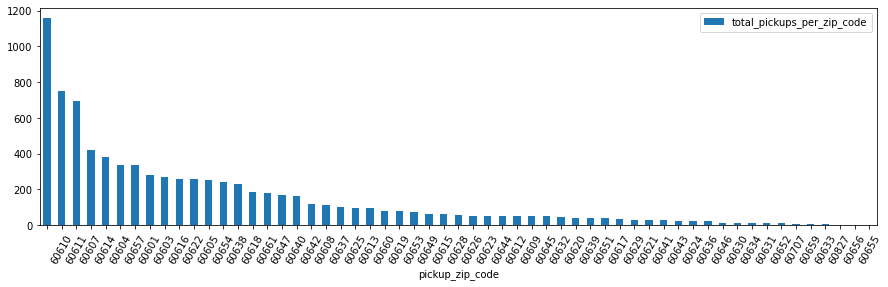

In [87]:
ax.plot.bar(x = 'pickup_zip_code', y = 'total_pickups_per_zip_code',rot = 60, figsize = (15,4))

In [88]:
ay = df.groupby(['dropoff_zip_code'])['start_day'].count().reset_index(name = 'total_pickups_per_zip_code')
ay = ay.sort_values(['total_pickups_per_zip_code'], ascending = False)
ay.head(10)

dropoff_zip_code  total_pickups_per_zip_code
9             60611                         730
8             60610                         703
51            60657                         491
12            60614                         481
5             60607                         452
0                                           398
48            60654                         381
2             60603                         361
20            60622                         345
14            60616                         280

<AxesSubplot:xlabel='dropoff_zip_code'>

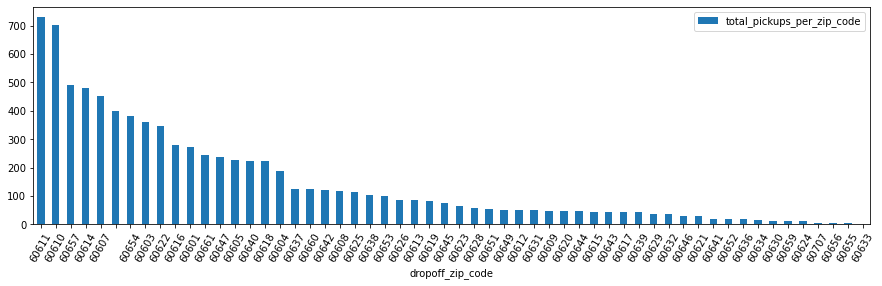

In [89]:
ay.plot.bar(x = 'dropoff_zip_code', y = 'total_pickups_per_zip_code',rot = 60, figsize = (15,4))

In [90]:
ab = df.groupby(['year'])['start_day'].count().reset_index(name = 'total_pickups_per_year')
ab

year  total_pickups_per_year
0  2019                    2648
1  2020                    1677
2  2022                    3936

In [91]:
ac = df.groupby(['start_day'])['end_day'].count().reset_index(name = 'total_pickups_per_dayofweek')
ac

start_day  total_pickups_per_dayofweek
0          0                          526
1          1                          527
2          2                          534
3          3                          598
4          4                          734
5          5                          834
6          6                         4508

<AxesSubplot:xlabel='start_day'>

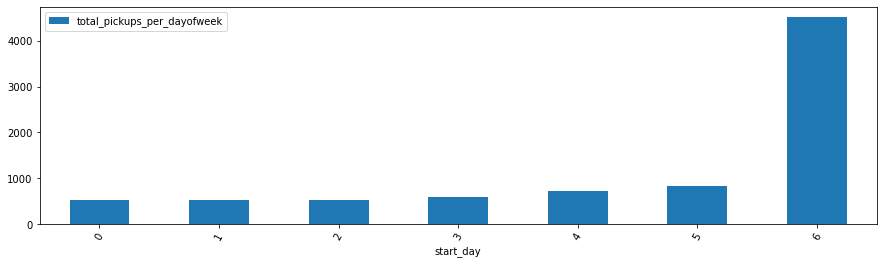

In [92]:
ac.plot.bar(x = 'start_day', y = 'total_pickups_per_dayofweek', rot = 60, figsize = (15,4))

In [93]:
ad = df.groupby(['end_day'])['start_day'].count().reset_index(name = 'total_dropoffs_per_dayofweek')
ad

end_day  total_dropoffs_per_dayofweek
0        0                           596
1        1                           524
2        2                           538
3        3                           595
4        4                           733
5        5                           824
6        6                          4451

<AxesSubplot:xlabel='end_day'>

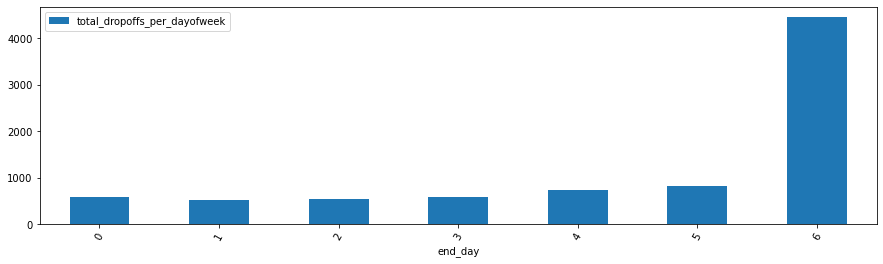

In [94]:
ad.plot.bar(x = 'end_day', y = 'total_dropoffs_per_dayofweek',rot = 60, figsize = (15,4))

In [95]:
p_zips = df['pickup_zip_code'].unique()
d_zips = df['dropoff_zip_code'].unique()

print(p_zips)
print(d_zips)


['60638' '60610' '' '60616' '60604' '60607' '60660' '60603' '60601'
 '60645' '60622' '60614' '60640' '60626' '60661' '60657' '60611' '60637'
 '60619' '60605' '60618' '60625' '60647' '60608' '60631' '60617' '60654'
 '60623' '60653' '60621' '60636' '60646' '60649' '60651' '60652' '60609'
 '60628' '60643' '60612' '60632' '60634' '60630' '60620' '60624' '60639'
 '60633' '60644' '60641' '60613' '60642' '60629' '60615' '60659' '60655'
 '60827' '60707' '60656']
['60614' '60604' '60607' '60610' '60640' '60660' '60601' '60618' ''
 '60616' '60657' '60654' '60651' '60637' '60605' '60603' '60647' '60631'
 '60628' '60629' '60622' '60608' '60661' '60626' '60611' '60625' '60646'
 '60649' '60621' '60638' '60645' '60653' '60619' '60642' '60632' '60623'
 '60643' '60636' '60639' '60634' '60652' '60644' '60617' '60612' '60620'
 '60609' '60707' '60655' '60613' '60633' '60641' '60624' '60615' '60630'
 '60659' '60656']


## Time Series Forecasting

In [96]:
df_rides_count = df.groupby(['start_date'])['trip_id'].count().reset_index(name ='Total_Number_of_rides')
df_rides_count

start_date  Total_Number_of_rides
0    2019-09-29                     37
1    2019-09-30                     29
2    2019-10-01                     41
3    2019-10-02                     43
4    2019-10-03                     36
..          ...                    ...
204  2020-06-28                      3
205  2020-09-23                      1
206  2020-09-24                      1
207  2022-07-31                   3911
208  2022-08-01                     25

[209 rows x 2 columns]

<div class="alert alert-info">

  
    
## Total number of rides per Month



</div>

In [97]:
monthly_df = df.groupby(['month',
                         'pickup_zip_code'])['trip_id'].count().reset_index(name ='Total_Number_of_rides_per_month')

monthly_df

month pickup_zip_code  Total_Number_of_rides_per_month
0        1                                               24
1        1           60601                                9
2        1           60603                               26
3        1           60604                                3
4        1           60605                               13
..     ...             ...                              ...
390     12           60657                               58
391     12           60659                                5
392     12           60660                               13
393     12           60661                               27
394     12           60707                                1

[395 rows x 3 columns]

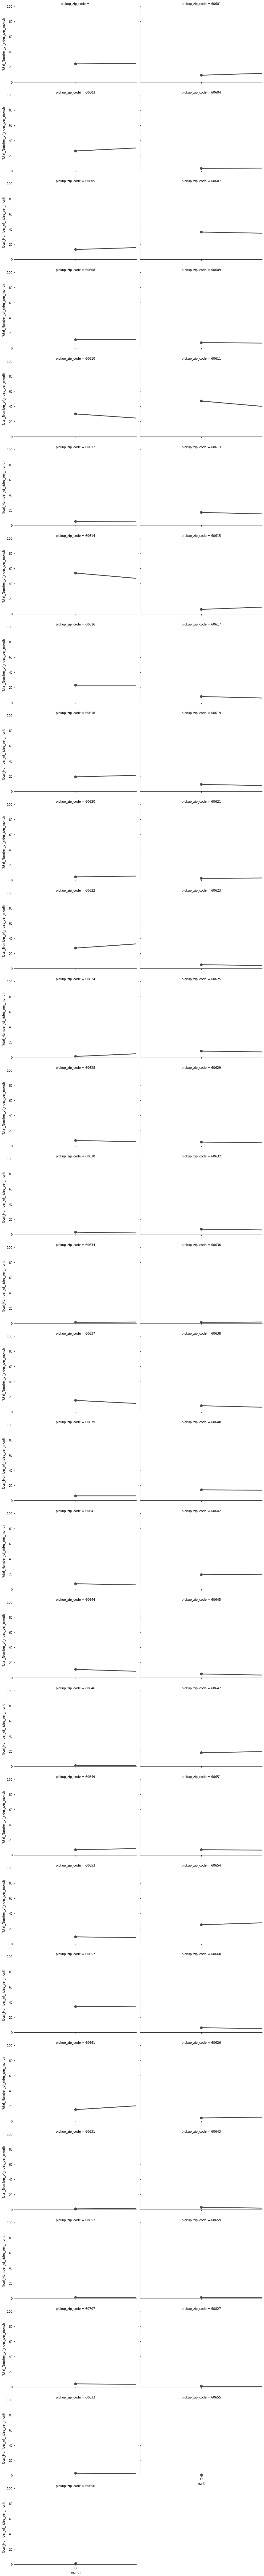

In [98]:
g = sns.FacetGrid(monthly_df, col="pickup_zip_code", col_wrap=2,  ylim=(0, 100), height=4, aspect=1.5)
g.map(sns.pointplot, "month", "Total_Number_of_rides_per_month", color=".3", ci=None);

In [99]:
slice_for_zip_code = df.loc[df['pickup_zip_code'] == "60604"]
slice_for_zip_code

id                                   trip_id  \
9       10  c7e47e647fd7ee468d2e96b30fc49faa9569477d   
16      17  ba96cbf4ac017857b45c3b71529eb00241c17d0d   
21      22  aa9abf994878dd9eec9d7142d9acd129d6afd543   
35      36  6a4de0250442a91ea8c04898b1e163d5b6706c12   
39      40  2b2a316e78d2b4525f33f74b884c56e556139fb7   
...    ...                                       ...   
7270  7289  f6d3edb489e4c5ad10926f0e733de8742efa0773   
7442  7402  f6d43a12ce89c8fb8dd2732d5574b8b5f4b41227   
7941  7958  f6d5ae2225c93057220779eea1669c171a667534   
8077  8114  f6d617013c36fb5b26729e5f44a5be66e9ae1119   
8081  8122  1713e0ee737d4806036bec964abafc20b736de71   

          trip_start_timestamp        trip_end_timestamp  \
9    2022-08-01 00:00:00+00:00 2022-08-01 00:00:00+00:00   
16   2022-08-01 00:00:00+00:00 2022-08-01 00:00:00+00:00   
21   2022-08-01 00:00:00+00:00 2022-08-01 00:00:00+00:00   
35   2022-07-31 23:45:00+00:00 2022-07-31 23:45:00+00:00   
39   2022-07-31 23:45:00+00:00 2022-08-01 00:00:00+00:00   
...                        ...                       ...   
7270 2019-12-20 14:15:00+00:00 2019-12-20 14:30:00+00:00   
7442 2019-12-13 16:15:00+00:00 2019-12-13 16:30:00+00:00   
7941 2019-10-19 06:15:00+00:00 2019-10-19 06:30:00+00:00   
8077 2019-12-07 08:45:00+00:00 2019-12-07 09:00:00+00:00   
8081 2020-05-08 12:30:00+00:00 2020-05-08 12:45:00+00:00   

      pickup_centroid_latitude  pickup_centroid_longitude  \
9                    41.878866                 -87.625192   
16                   41.878866                 -87.625192   
21                   41.878866                 -87.625192   
35                   41.878866                 -87.625192   
39                   41.878866                 -87.625192   
...                        ...                        ...   
7270                 41.878866                 -87.625192   
7442                 41.878866                 -87.625192   
7941                 41.878866                 -87.625192   
8077                 41.878866                 -87.625192   
8081                 41.878866                 -87.625192   

      dropoff_centroid_latitude  dropoff_centroid_longitude pickup_zip_code  \
9                     41.878866                  -87.625192           60604   
16                    41.878866                  -87.625192           60604   
21                    41.899602                  -87.633308           60604   
35                    41.878866                  -87.625192           60604   
39                    41.922686                  -87.649489           60604   
...                         ...                         ...             ...   
7270                  41.812949                  -87.617860           60604   
7442                  41.842076                  -87.633973           60604   
7941                  41.761578                  -87.572782           60604   
8077                  41.901207                  -87.676356           60604   
8081                  41.901207                  -87.676356           60604   

     dropoff_zip_code  start_date start_time    end_date  end_time  year  \
9               60604  2022-08-01   00:00:00  2022-08-01  00:00:00  2022   
16              60604  2022-08-01   00:00:00  2022-08-01  00:00:00  2022   
21              60610  2022-08-01   00:00:00  2022-08-01  00:00:00  2022   
35              60604  2022-07-31   23:45:00  2022-07-31  23:45:00  2022   
39              60614  2022-07-31   23:45:00  2022-08-01  00:00:00  2022   
...               ...         ...        ...         ...       ...   ...   
7270            60653  2019-12-20   14:15:00  2019-12-20  14:30:00  2019   
7442            60616  2019-12-13   16:15:00  2019-12-13  16:30:00  2019   
7941            60649  2019-10-19   06:15:00  2019-10-19  06:30:00  2019   
8077            60622  2019-12-07   08:45:00  2019-12-07  09:00:00  2019   
8081            60622  2020-05-08   12:30:00  2020-05-08  12:45:00  2020   

      month  start_

In [100]:
df_deliveries_count = slice_for_zip_code.groupby(['start_date'])['trip_id'].count().reset_index(name ='Total_Number_of_rides')
df_deliveries_count

start_date  Total_Number_of_rides
0   2019-09-30                      1
1   2019-10-01                      1
2   2019-10-09                      1
3   2019-10-19                      1
4   2019-10-21                      1
5   2019-10-22                      1
6   2019-10-24                      1
7   2019-10-27                      1
8   2019-10-28                      1
9   2019-12-07                      1
10  2019-12-08                      1
11  2019-12-13                      2
12  2019-12-19                      1
13  2019-12-20                      1
14  2019-12-23                      1
15  2019-12-25                      1
16  2020-01-20                      1
17  2020-01-26                      1
18  2020-01-28                      1
19  2020-02-01                      1
20  2020-02-06                      1
21  2020-02-15                      1
22  2020-02-20                      1
23  2020-03-09                      1
24  2020-03-16                      1
25  2020-03-20                      1
26  2020-05-08                      1
27  2020-05-29                      1
28  2020-06-06                      1
29  2022-07-31                    306
30  2022-08-01                      3

In [101]:
df_deliveries_count["start_date"] =  pd.to_datetime(df["start_date"], format="%Y/%m/%d")

In [102]:
df_deliveries_count = df_deliveries_count.rename(columns = {'start_date': 'ds',
                                'Total_Number_of_rides': 'y'})
df_deliveries_count

ds    y
0  2022-08-01    1
1  2022-08-01    1
2  2022-08-01    1
3  2022-08-01    1
4  2022-08-01    1
5  2022-08-01    1
6  2022-08-01    1
7  2022-08-01    1
8  2022-08-01    1
9  2022-08-01    1
10 2022-08-01    1
11 2022-08-01    2
12 2022-08-01    1
13 2022-08-01    1
14 2022-08-01    1
15 2022-08-01    1
16 2022-08-01    1
17 2022-08-01    1
18 2022-08-01    1
19 2022-08-01    1
20 2022-08-01    1
21 2022-08-01    1
22 2022-08-01    1
23 2022-08-01    1
24 2022-08-01    1
25 2022-07-31    1
26 2022-07-31    1
27 2022-07-31    1
28 2022-07-31    1
29 2022-07-31  306
30 2022-07-31    3

In [103]:
df_deliveries_count.dtypes

ds    datetime64[ns]
y              int64
dtype: object

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: C:\Users\Admin\AppData\Local\Temp\tmpdpwxic4p\qc_uazdo.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Admin\AppData\Local\Temp\tmpdpwxic4p\git26395.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Admin\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=95345', 'data', 'file=C:\\Users\\Admin\\AppData\\Local\\Temp\\tmpdpwxic4p\\qc_uazdo.json', 'init=C:\\Users\\Admin\\AppData\\Local\\Temp\\tmpdpwxic4p\\git26395.json', 'output', 'file=C:\\Users\\Admin\\AppData\\Local\\Temp\\tmpe827kdpc\\prophet_model-20220827110517.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:05:17 

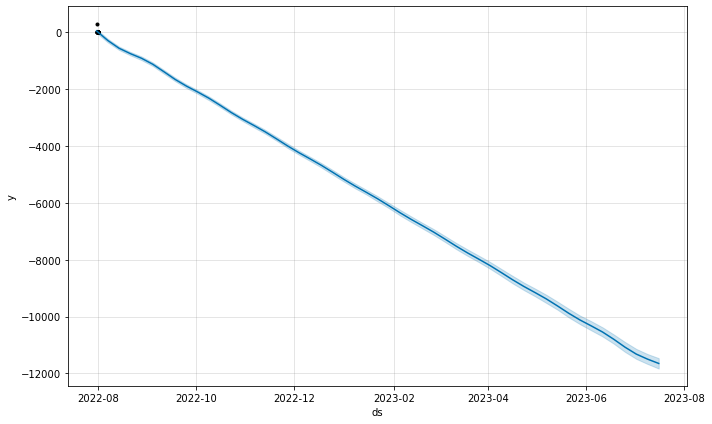

In [104]:
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(df_deliveries_count) 
future_dates = model.make_future_dataframe(periods = 50, freq='W')
forecast = model.predict(future_dates)

model.plot(forecast);

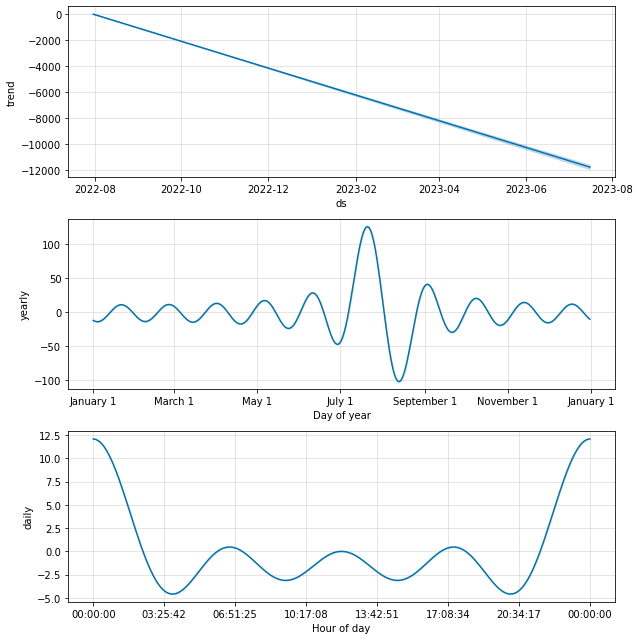

In [105]:
model.plot_components(forecast);

In [106]:
plot_plotly(model, forecast)

In [107]:
plot_components_plotly(model, forecast)

<div class="alert alert-info">   

### Forecasting rides for all zip codes:
    
</div>

In [108]:
df_deliveries_allzip = df.groupby(['start_date'])['trip_id'].count().reset_index(name ='Total_Number_of_rides')
df_deliveries_allzip["start_date"] =  pd.to_datetime(df["start_date"], format="%Y/%m/%d")
df_deliveries_allzip = df_deliveries_allzip.rename(columns = {'start_date': 'ds',
                                'Total_Number_of_rides': 'y'})

In [109]:
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(df_deliveries_allzip) 
future_dates = model.make_future_dataframe(periods = 50, freq='W')
forecast = model.predict(future_dates)

plot_plotly(model, forecast)

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Admin\AppData\Local\Temp\tmpdpwxic4p\hfeel47o.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Admin\AppData\Local\Temp\tmpdpwxic4p\_qcqcbfq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Admin\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=72527', 'data', 'file=C:\\Users\\Admin\\AppData\\Local\\Temp\\tmpdpwxic4p\\hfeel47o.json', 'init=C:\\Users\\Admin\\AppData\\Local\\Temp\\tmpdpwxic4p\\_qcqcbfq.json', 'output', 'file=C:\\Users\\Admin\\AppData\\Local\\Temp\\tmpeug6ratn\\prophet_model-20220827111018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:10:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] sta

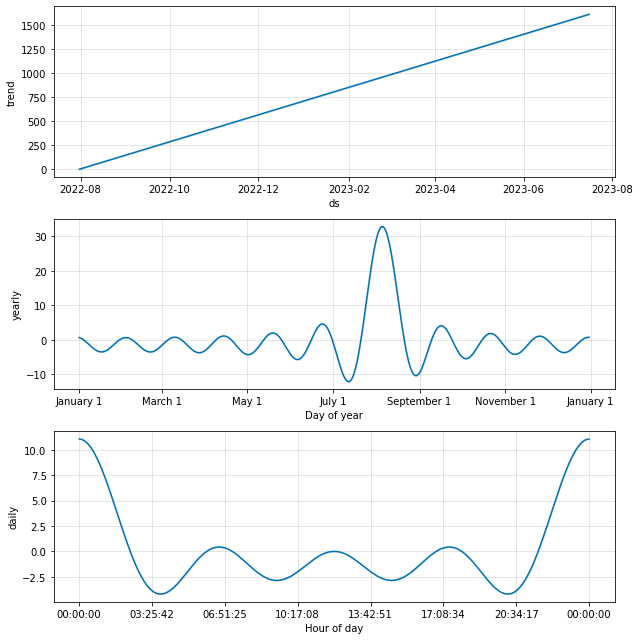

In [110]:
model.plot_components(forecast);